# **Second Stage Analysis**
#### *Separating Risk Level 5 vs 4*

Below is the sequence of analyses performed to assess the feasibility of a second stage model aimed at distinguishing hazard levels 5 from 4, starting from the existing XGBoost Random Forest (classes 1-4 encoded as 0-3).

The idea is to understand the feasibility of a second stage model that can differentiate between the highest risk level (5) and the next highest (4), between those ones identified as 4 in the first stage model, to produce a cascade system.

In [ ]:
%pip install -r ../requirements.txt

## 0. **Setup**

In [10]:
import os
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix, classification_report,
    average_precision_score, recall_score,
    precision_score, f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest

RES_DIR = os.path.join('..', 'resources')
IMG_DIR = os.path.join("..", "results", "shap", "imgs")
CSV_DIR = os.path.join("..", "results", "shap", "csv")
os.makedirs(RES_DIR, exist_ok=True)
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

DATA_FILE = "reduced_data_rf2_tidy.csv"

MODEL_NAME = 'XGB_ROS_RS_NoDR_Opt'
MODEL_PATH = os.path.join('..', 'models', f"{MODEL_NAME}.pkl")


In [11]:
# Model
with open(MODEL_PATH, 'rb') as f:
    model_14 = joblib.load(f)
model_14

Pipeline(steps=[('column_select',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  0                HN24
1             HN24_7d
2           Pen_depth
3             HN72_24
4             MS_Snow
5         min_ccl_pen
6     wind_trans24_3d
7                 SWE
8                  TA
9     wind_trans24_7d
10                 Sd
11           sn38_pwl
13                 Qw
14       wind_trans24
15                TS2
16                 Sn
18                 VW
20           sk38_pwl
21            MS_Wind
22                TS0
Name: Feature, dtype: object)])),
                ('sampler', RandomOverSampler(random_state=42)),
                ('scaler', RobustScaler(...
                               feature_types=None, feature_weights=None,
                               gamma=0.06983140212909127, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.02177217804898876, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=2, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=371, n_jobs=None, ...))])

In [12]:
# Data loading
RESOURCE_DIR = "resources"
CSV_FILE = "reduced_data_rf2_tidy.csv"
full_path = os.path.join('..', RESOURCE_DIR, CSV_FILE)
df = pd.read_csv(full_path, parse_dates=['datum'])

Data preparation and temporal splits:

In [13]:
# Map label 5 -> 4, then encode classes 1–4 to 0–3
y = df['dangerLevel'].replace({5: 4})
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X = df.drop(columns=['dangerLevel','datum'])

# Temporal split by winter season (Nov–Mar)
winter_year = df['datum'].dt.year.where(
    df['datum'].dt.month >= 11,
    df['datum'].dt.year - 1
)
groups = winter_year.values
uniq = np.sort(np.unique(groups))
train_idx = groups != uniq[-2]  # all but last 2 seasons
test_idx  = groups == uniq[-2]

X_train, y_train = X[train_idx], y_encoded[train_idx]
X_test,  y_test  = X[test_idx],  y_encoded[test_idx]
# Fit the base 1–4 model
model_14.fit(X_train, y_train)

# True labels 1–5 for evaluation
y_test_orig = df['dangerLevel'].iloc[np.where(test_idx)[0]]

In [14]:
from collections import Counter

class_counts = Counter(df['dangerLevel'].iloc[np.where(train_idx)[0]])
print("Number of samples per class in the train set:")
for label, count in class_counts.items():
    print(f"Class {label}: {count} samples")
class_counts = Counter(y_test_orig)
print("\nNumber of samples per class in the test set:")
for label, count in class_counts.items():
    print(f"Class {label}: {count} samples")

Number of samples per class in the train set:
Class 2: 6487 samples
Class 1: 6409 samples
Class 3: 6906 samples
Class 4: 892 samples
Class 5: 47 samples

Number of samples per class in the test set:
Class 2: 704 samples
Class 1: 425 samples
Class 3: 623 samples
Class 4: 86 samples
Class 5: 22 samples


## 4.1. Analysis

### 4.1.1 Data overview

True 4 and 5 labels on 2 principal components:

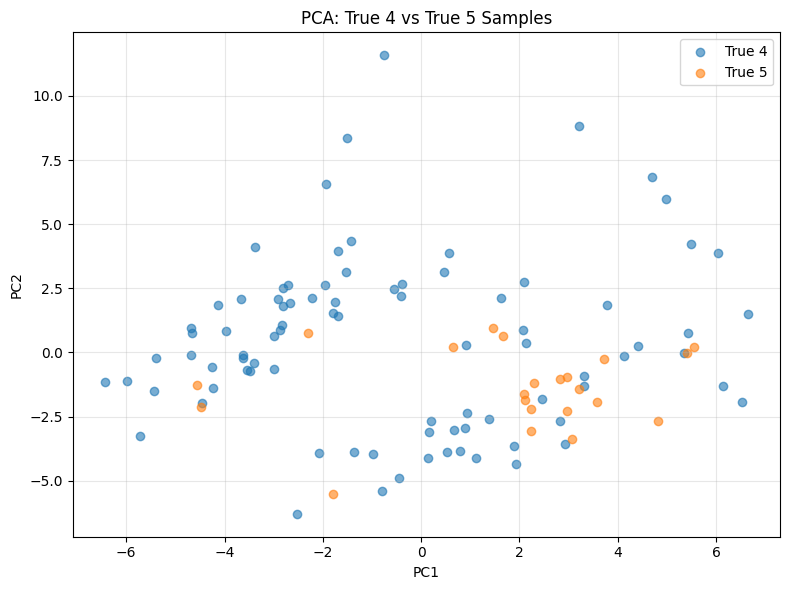

In [24]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 4-5 class samples
mask45 = y_test_orig.isin([4, 5]).values
X_45 = X_test[mask45]
y_45 = y_test_orig[mask45]

# PCA
scaler = StandardScaler()
X_45_scaled = scaler.fit_transform(X_45)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_45_scaled)

# Plot
plt.figure(figsize=(8, 6))
# Crea array booleano per separare i due gruppi
mask_true4 = (y_45 == 4).values
mask_true5 = (y_45 == 5).values
plt.scatter(
    X_pca[mask_true4, 0], X_pca[mask_true4, 1],
    c='tab:blue', alpha=0.6, label='True 4'
)
plt.scatter(
    X_pca[mask_true5, 0], X_pca[mask_true5, 1],
    c='tab:orange', alpha=0.6, label='True 5'
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: True 4 vs True 5 Samples')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


On most important features:

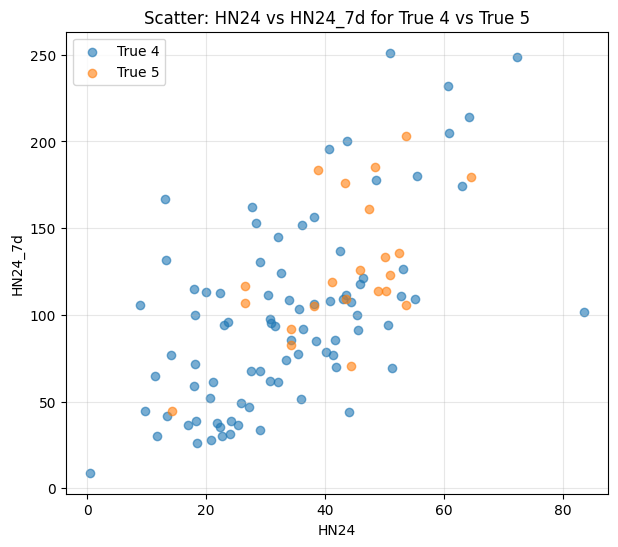

In [23]:
import matplotlib.pyplot as plt

# Best features for 4-5 class
feat_x = 'HN24'
feat_y = 'HN24_7d'

# 4-5 class observations
mask45 = y_test_orig.isin([4,5])
X45 = X_test[mask45]
y45 = y_test_orig[mask45]

plt.figure(figsize=(7,6))
plt.scatter(
    X45[feat_x][y45==4], X45[feat_y][y45==4],
    c='tab:blue', alpha=0.6, label='True 4'
)
plt.scatter(
    X45[feat_x][y45==5], X45[feat_y][y45==5],
    c='tab:orange', alpha=0.6, label='True 5'
)
plt.xlabel(feat_x)
plt.ylabel(feat_y)
plt.title(f'Scatter: {feat_x} vs {feat_y} for True 4 vs True 5')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### 4.1.1 Baseline 1-4 model

The baseline is used to measure how many true examples of class 5 the first stage manages to at least classify as “4” (and therefore can move on to the second stage) compared to how many end up directly in 1, 2 or 3 (and are lost). In this way, precise numbers of precision, recall and F₁ on “true 4 vs true 5” are obtained, establishing the starting point (recall 5 = 0) and the gap that each second stage will have to fill.

In [ ]:
# Predict and realign 0–3 -> 1–4
y_pred1 = model_14.predict(X_test) + 1

# Confusion matrix for true vs predicted 4/5
cm1 = confusion_matrix(
    y_test_orig[mask45],
    y_pred1[mask45],
    labels=[4,5]
)
print("Confusion matrix (4 vs 5):")
print(pd.DataFrame(cm1,
                   index=['true 4','true 5'],
                   columns=['pred 4','pred 5']))

# Classification report (4 vs 5)
print("\nClassification report (4 vs 5):")
print(classification_report(
    y_test_orig[mask45],
    y_pred1[mask45],
    labels=[4,5],
    target_names=['class 4','class 5'],
    zero_division=0
))

Confusion matrix (4 vs 5):
        pred 4  pred 5
true 4      50       0
true 5      20       0

Classification report (4 vs 5):
              precision    recall  f1-score   support

     class 4       0.71      0.58      0.64        86
     class 5       0.00      0.00      0.00        22

   micro avg       0.71      0.46      0.56       108
   macro avg       0.36      0.29      0.32       108
weighted avg       0.57      0.46      0.51       108



Among the 108 true 4-or-5 samples, the first-stage model correctly labeled 50 of 86 true 4s (recall₄ = 0.58, precision₄ = 0.71) but failed to identify any of the 22 true 5s (obiviously, since it is a 1-4 classificator). Of those 22 true 5s, 20 were misclassified as 4 (so could still be passed to stage two) and 2 were misclassified as 1–3 (irrecoverable). 

These metrics establish the baseline: no true 5s are recovered, and the stage-two method must first retrieve at least the 20 true 5s that landed in “predicted 4.”


### 4.1.2 Margin Analysis P(4)-P(3)

In this section, we extract the first-stage probabilities for classes 4 and 3 and compute their difference (“margin = P(4)–P(3)”) to see if true level-5 events can be distinguished from level-4. We then evaluate this margin by calculating its Precision–Recall AUC and searching for an optimal threshold, followed by training a logistic meta-classifier on $\{P(4),\,P(4)–P(3)\}$ to further separate true 4 vs true 5.


In [26]:
# Extract class probabilities
proba = model_14.predict_proba(X_test)
idx4 = list(model_14.classes_).index(3)  # model class 3 -> label 4
idx3 = list(model_14.classes_).index(2)  # model class 2 -> label 3
p4 = proba[:, idx4]
p3 = proba[:, idx3]
margin = p4 - p3

# Compute Precision–Recall AUC on margin
y_bin = (y_test_orig[mask45] == 5).astype(int)
aupr = average_precision_score(y_bin, margin[mask45])
print(f"Margin AUPR: {aupr:.3f}")

Margin AUPR: 0.282


An AUPR of 0.282 indicates that the margin $P(4)–P(3)$ has very limited ability to rank true level-5 samples above true level-4 ones. In other words, the overlap between the margin distributions for true 4 and true 5 is substantial, so relying on this single score yields poor discrimination.

Histogram of the Margin P(4)–P(3):

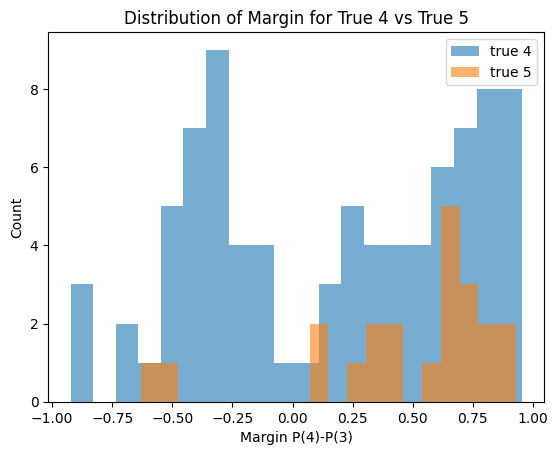

In [27]:
import matplotlib.pyplot as plt

plt.hist(margin[y_test_orig.isin([4,5]) & (y_test_orig==4)], bins=20, alpha=0.6, label='true 4')
plt.hist(margin[y_test_orig.isin([4,5]) & (y_test_orig==5)], bins=20, alpha=0.6, label='true 5')
plt.xlabel('Margin P(4)-P(3)')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Margin for True 4 vs True 5')
plt.show()

In fact, the histogram shows that true 5 samples tend to cluster at higher positive margins (P(4)–P(3)), while true 4 samples are more spread out toward lower values. However, there is still substantial overlap between the two distributions, confirming that the margin alone cannot cleanly separate level 5 from level 4.

Optimal threshold search (F1):

In [ ]:
best = {'th': None, 'f1': 0, 'recall': 0, 'precision': 0}
for t in np.linspace(margin.min(), margin.max(), 101):
    y_g = np.where(margin[mask45] < t, 5, 4)
    y_b = (y_g == 5).astype(int)
    if y_b.sum() == 0:
        continue
    r = recall_score(y_bin, y_b)
    p = precision_score(y_bin, y_b, zero_division=0)
    f = f1_score(y_bin, y_b)
    if f > best['f1']:
        best.update({'th': t, 'f1': f, 'recall': r, 'precision': p})
print(best)

{'th': np.float32(0.81980264), 'f1': np.float64(0.3418803418803419), 'recall': np.float64(0.9090909090909091), 'precision': np.float64(0.21052631578947367)}


The optimal margin threshold is approximately 0.82, which gives an F₁ score of 0.342, recall of 0.909, and precision of 0.211. In other words, using `margin < 0.82` flags almost all true‐5 samples (high recall) but also yields many false alarms (low precision), so a single cut‐off on $P(4) - P(3)$ remains insufficiently discriminative.


#### **Meta-Classifier** on [p4, margin]:

Now, we train a logistic regression meta‐classifier using the two features $\{p_4,\,p_4 - p_3\}$ (i.e., the probability of class 4 and the margin) extracted from the first stage. By fitting on true 4 vs true 5 examples, the goal is to learn a linear decision boundary that better separates rare level 5 events from level 4 than a single‐threshold rule on the margin.


In [ ]:
# Prepare meta-training features
proba_tr = model_14.predict_proba(X_train)
p4_tr = proba_tr[:,idx4]
p3_tr = proba_tr[:,idx3]
margin_tr = p4_tr - p3_tr
y_tr_orig = df['dangerLevel'].iloc[np.where(train_idx)[0]]
mask_tr45 = y_tr_orig.isin([4,5])
X_meta_tr = np.vstack([p4_tr,margin_tr]).T[mask_tr45]
y_meta_tr = (y_tr_orig[mask_tr45]==5).astype(int)
# Fit LogisticRegression
meta_clf = LogisticRegression(class_weight='balanced',max_iter=1000)
meta_clf.fit(X_meta_tr, y_meta_tr)
X_meta_test = np.vstack([p4, margin]).T[mask45]  # define test features for meta-classifier

# Evaluate on test
y_meta_pred = meta_clf.predict(X_meta_test)
print(classification_report(
    y_test_orig[mask45],
    np.where(y_meta_pred == 1, 5, 4),
    labels=[4,5],
    target_names=['class 4','class 5'],
    zero_division=0
))
print("Meta AUPR:",
      average_precision_score(y_bin,
          meta_clf.predict_proba(X_meta_test)[:, 1]
      )
)

              precision    recall  f1-score   support

     class 4       0.79      0.88      0.84        86
     class 5       0.17      0.09      0.12        22

    accuracy                           0.72       108
   macro avg       0.48      0.49      0.48       108
weighted avg       0.66      0.72      0.69       108

Meta AUPR: 0.2819514338047216


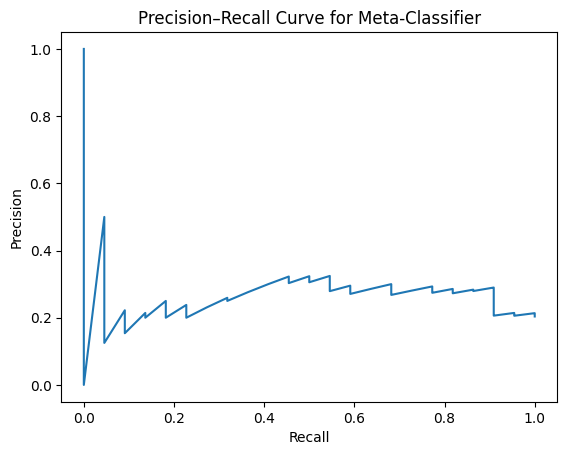

In [ ]:
from sklearn.metrics import precision_recall_curve

y_meta_score = meta_clf.predict_proba(X_meta_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_bin, y_meta_score)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Meta-Classifier')
plt.show()

The meta‐classifier achieves high accuracy on class 4 (precision 0.79, recall 0.88, F₁ 0.84 over 86 samples) but still struggles to identify class 5 (precision 0.17, recall 0.09, F₁ 0.12 over 22 samples). In other words, out of 22 true 5 cases, it only correctly flags about 2, while misclassifying the remaining 20 as class 4. The overall AUPR of 0.282 confirms that even with a linear model on $\{p_4,\;p_4 - p_3\}$, the rare level-5 events remain poorly separable from level 4. The precision–recall curve further shows that increasing recall for level 5 quickly drives precision down, underlining that this meta-classifier does not significantly improve discrimination beyond what the simple margin threshold provided.


### 4.1.3 **Outlier detection** using IsolationForest

In this section, we train an IsolationForest on only the true class-4 training samples (treating them as “normal”) and then use it to detect true class-5 test samples as outliers. The contamination parameter is set to the estimated fraction of class-5 examples in training (82/1200). On the test subset of true 4 vs true 5, any sample with an IsolationForest anomaly score below zero is labeled as 5 (outlier); otherwise, it is labeled as 4. We then evaluate precision, recall, F₁, and AUPR to see if treating class-5 events as anomalies helps separate them from class-4.


In [ ]:
# Train on true 4 only
y_train_orig = df['dangerLevel'].iloc[np.where(train_idx)[0]]
iso = IsolationForest(
    contamination=82/1200, random_state=42
)
iso.fit(X_train[y_train_orig == 4])

# Predict on test subset
y_iso_pred = np.where(
    iso.decision_function(X_test[mask45]) < 0, 5, 4
)
print(classification_report(
    y_test_orig[mask45], y_iso_pred,
    labels=[4,5], target_names=['class 4','class 5'],
    zero_division=0
))
print("Iso AUPR:",
      average_precision_score(y_bin,
          -iso.decision_function(X_test[mask45])
      )
)

              precision    recall  f1-score   support

     class 4       0.79      0.97      0.87        86
     class 5       0.00      0.00      0.00        22

    accuracy                           0.77       108
   macro avg       0.40      0.48      0.43       108
weighted avg       0.63      0.77      0.69       108

Iso AUPR: 0.21426316263101974


All 22 true class-5 samples are still missed (precision₅ = 0, recall₅ = 0), meaning the IsolationForest never flags any as outliers. Meanwhile, it correctly labels most true 4s (precision₄ = 0.79, recall₄ = 0.97). The overall AUPR of 0.214 confirms that treating level-5 events as anomalies on true-4 data yields even weaker separation than the margin or meta-classifier approaches.

## 4.2 Conclusion

In summary, none of the second‐stage approaches—margin thresholding, logistic meta‐classification on $\{p_4,\,p_4 - p_3\}$, or treating true‐5 events as outliers via IsolationForest—provided reliable separation of level-5 from level-4 samples. All methods yielded very low AUPR (≈0.21–0.32) and near-zero recall on true-5 cases when optimized, demonstrating that the rare level-5 patterns are too similar to level-4 within the first‐stage feature space. These results indicate that a purely probability-based or outlier-based postprocessing is insufficient; future work should instead leverage physical or rule-based criteria (e.g., extreme snow-depth thresholds, penetration depth) to isolate the few genuine level-5 events.
